In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, date, timedelta
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA


In [2]:
# for stock data
stock_data = pd.read_csv("C:/Users/HP/OneDrive/Desktop/Dissertation/Comparison-of-effect-of-Inflation-in-Stock-market-Indices/US/NVDA.csv", index_col=0, parse_dates=[0], dayfirst=True,
                         header=0, names=['Date', 'open', 'high', 'low', 'close', 'volume'])

# for index data
# pd.read_csv("C:/Users/HP/OneDrive/Desktop/Dissertation/Comparison-of-effect-of-Inflation-in-Stock-market-Indices/S&P500.csv", index_col=0, parse_dates=[0], dayfirst=True,
#                          header=0, names=['Date', 'open', 'high', 'low', 'close', 'adj_close', 'volume'])

stock_data.index = stock_data.index.strftime("%Y-%m")
stock_data.index = pd.to_datetime(stock_data.index)
stock_data = stock_data.sort_index()
print("Stock data\n")
print(stock_data.head())


Stock data

             open    high    low  close    volume
Date                                             
1999-12-01  34.63   47.44  34.63  46.94  10244900
2000-01-01  47.25   48.25  35.00  37.06  10294700
2000-02-01  37.13   68.25  35.75  64.00  19085100
2000-03-01  64.00  150.00  57.50  84.48  36567000
2000-04-01  83.72  110.40  57.00  89.13  13503600


In [3]:
inflation_data = pd.read_csv("C:/Users/HP/OneDrive/Desktop/Dissertation/Comparison-of-effect-of-Inflation-in-Stock-market-Indices/inflation rate 2000-2023.csv")

inflation_data = inflation_data.set_index('Date')
inflation_data.index = pd.to_datetime(inflation_data.index)
print("Inflation data\n")
print(inflation_data.head())

Inflation data

            us_inflation_rate  us_share_price  china_inflation_rate  \
Date                                                                  
2000-01-01           2.738892        39.55779                  -0.2   
2000-02-01           3.221884        43.48396                   0.7   
2000-03-01           3.757576        46.61248                  -0.2   
2000-04-01           3.068592        49.17913                  -0.3   
2000-05-01           3.188929        49.00218                   0.1   

            china_share_price  india_inflation_rate  india_share_price  
Date                                                                    
2000-01-01           19.75834              2.619048           62.86602  
2000-02-01           20.65533              3.614458           59.92387  
2000-03-01           19.18312              4.830918           61.62468  
2000-04-01           17.93419              5.542169           64.01819  
2000-05-01           15.61101              5.011

In [4]:
data = pd.concat([stock_data,
                  inflation_data.loc[:, ['us_inflation_rate', 'us_share_price']]],
                  axis='columns')

data.index = pd.to_datetime(data.index)

data = data.dropna(subset=['us_inflation_rate', 'us_share_price'])


In [5]:
def plot_price(column):
    plt.figure(figsize=(15, 7))
    sns.lineplot(data=column, x=column.index, y=column, color="midnightblue")
    plt.title(f"{column.name} price distribution from 2000-present")
    plt.ylabel(f"{column.name} price")
    for yr in range(column.index[0].year, column.index[-1].year):
        plt.axvline(pd.to_datetime(str(yr)+'-01-01'), color='black', ls="--", alpha=0.3)
    plt.show()

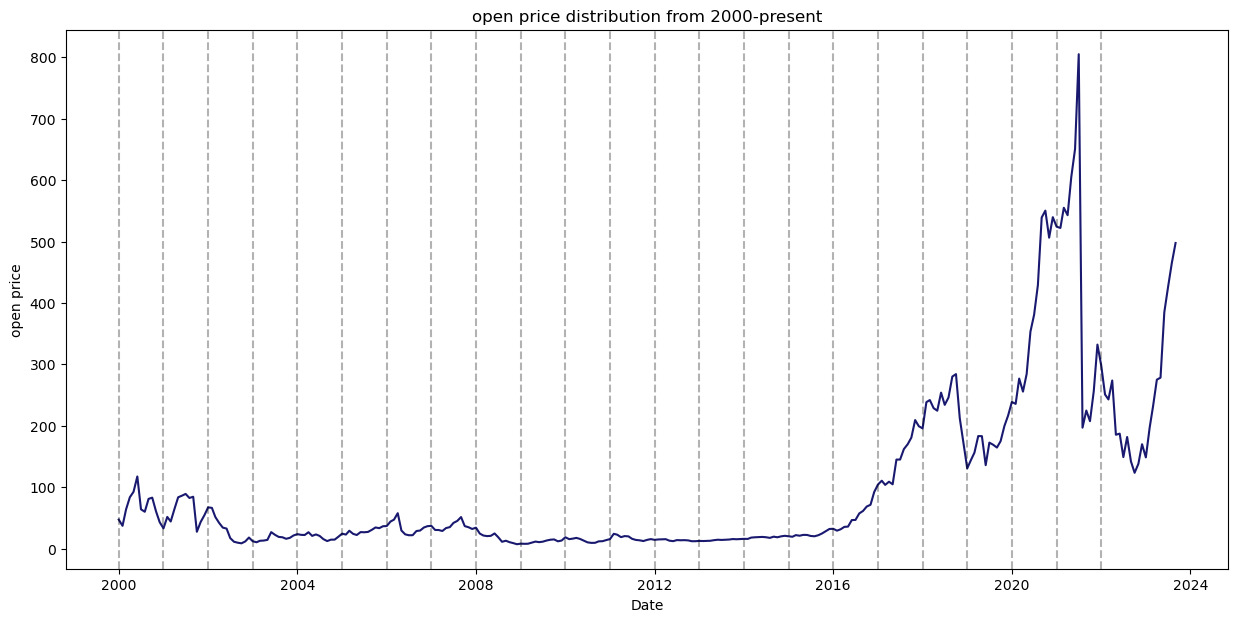

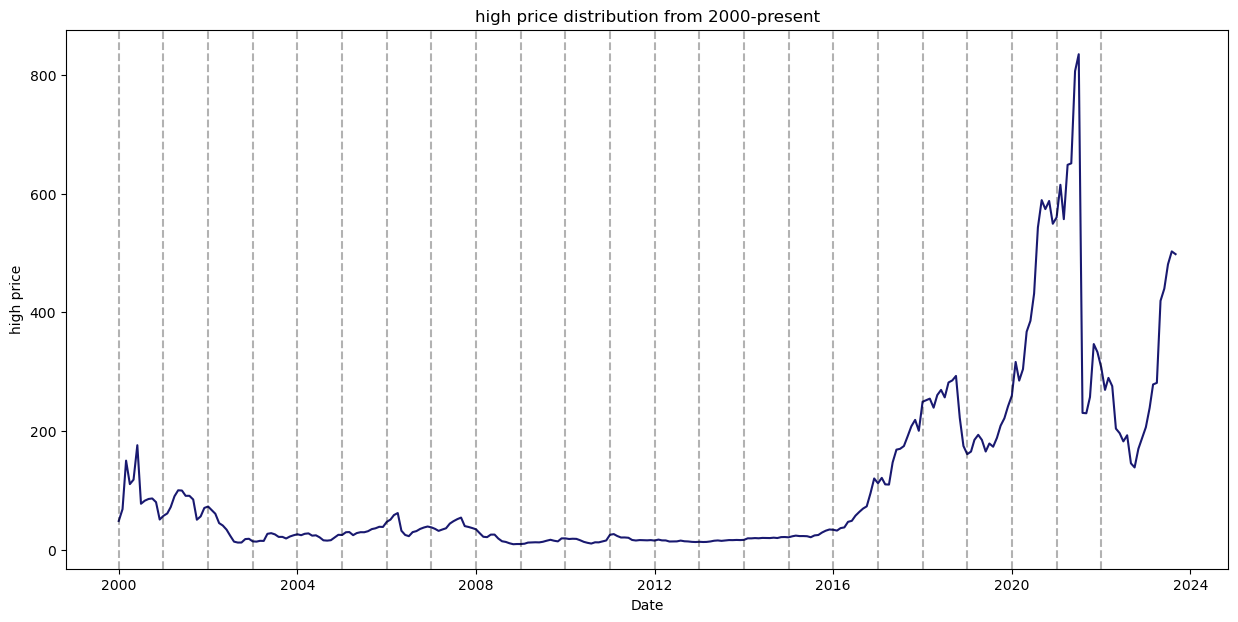

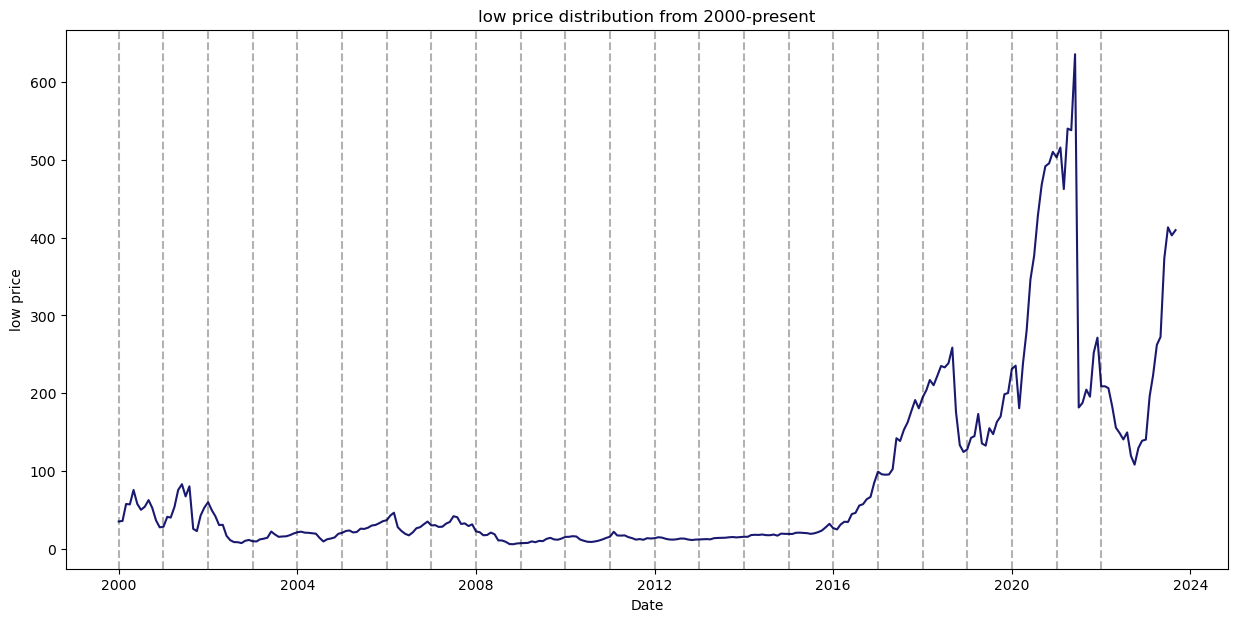

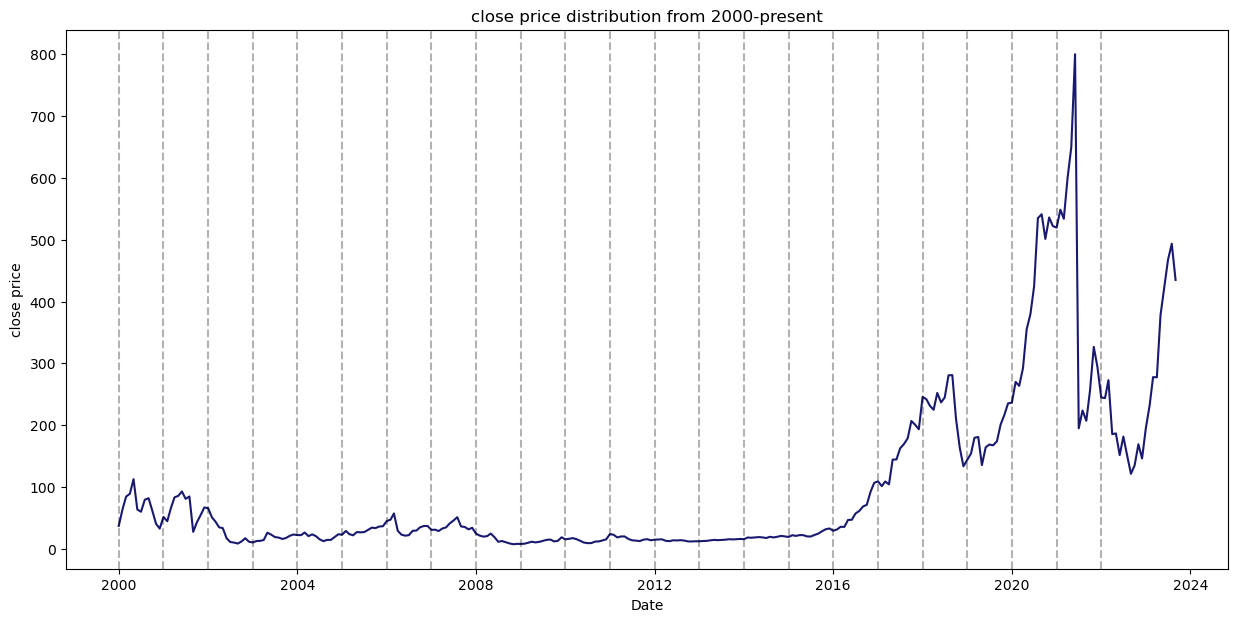

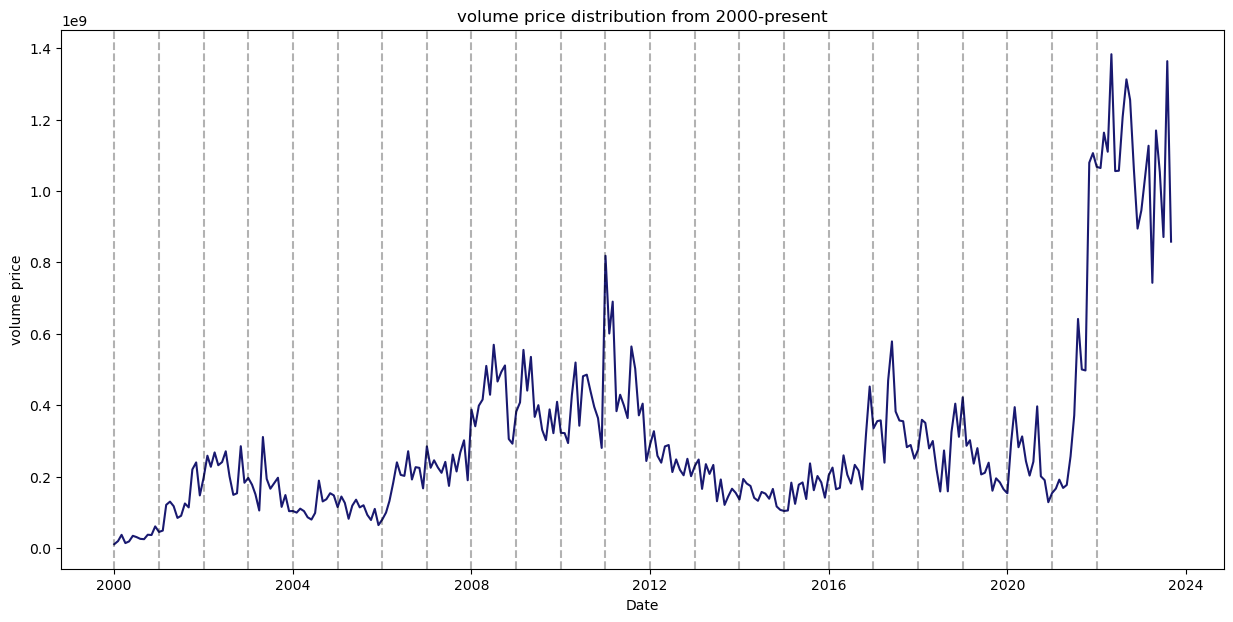

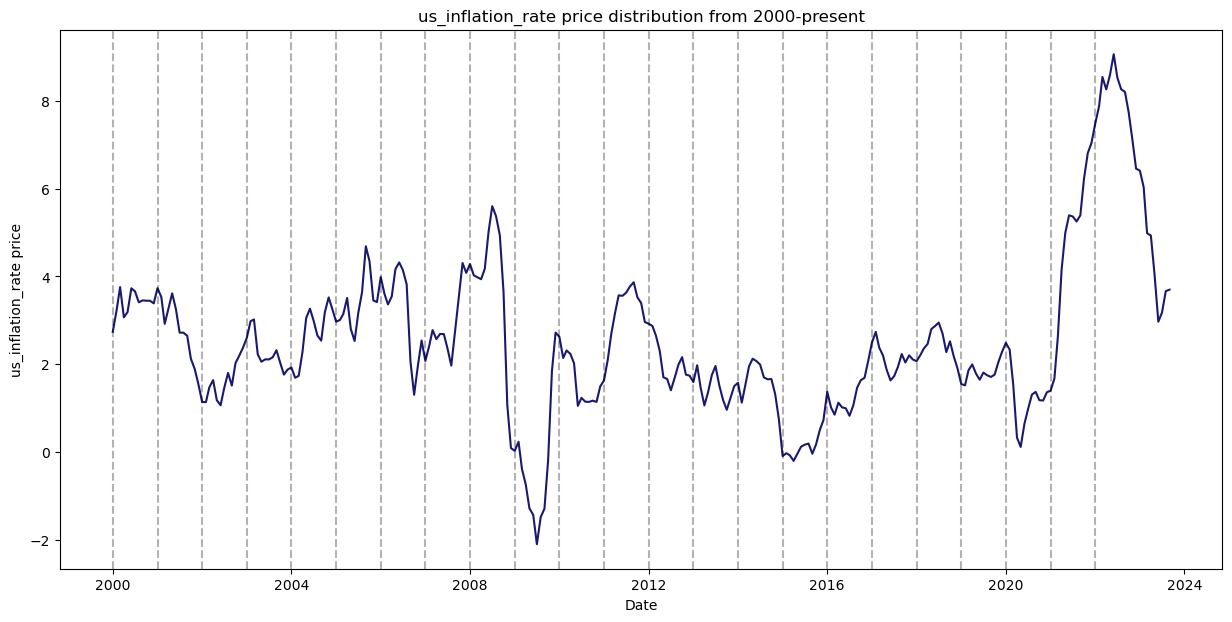

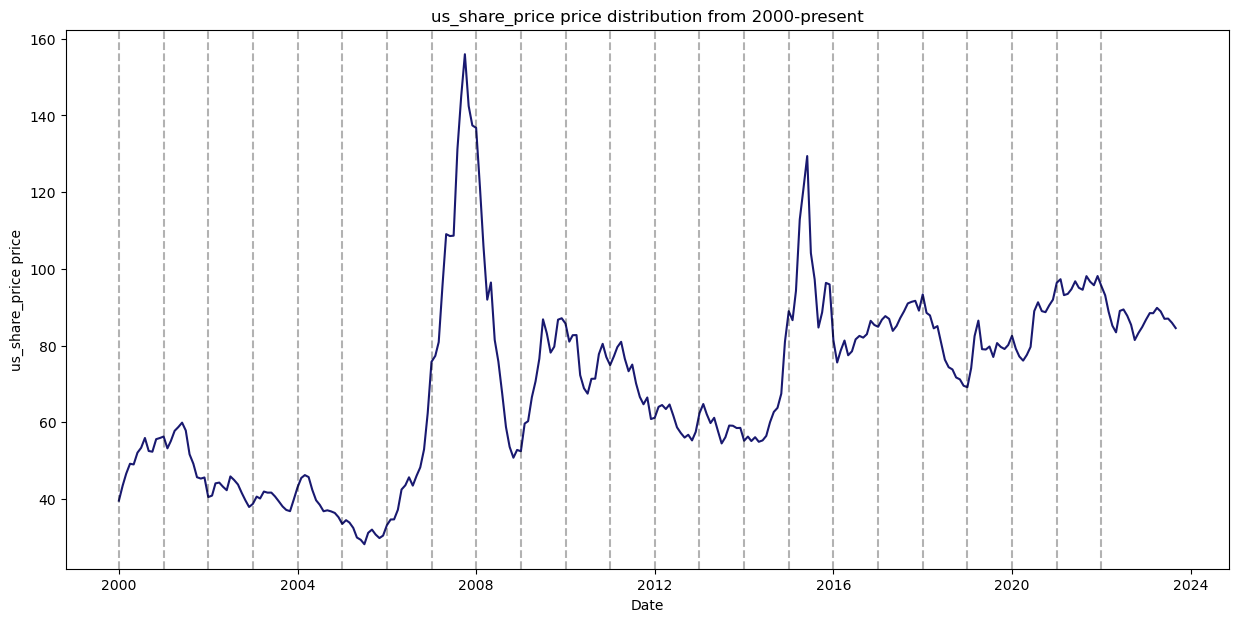

In [6]:
for col in data.columns:
    plot_price(data[col])

In [7]:
close_data = data['close'].diff().dropna()
open_data = data['open'].diff().dropna()
high_data = data['high'].diff().dropna()
low_data = data['low'].diff().dropna()
volume_data = data['volume'].diff().dropna()
us_inflation_rate_data = data['us_inflation_rate'].diff().dropna()
us_share_price_data = data['us_share_price'].diff().dropna()

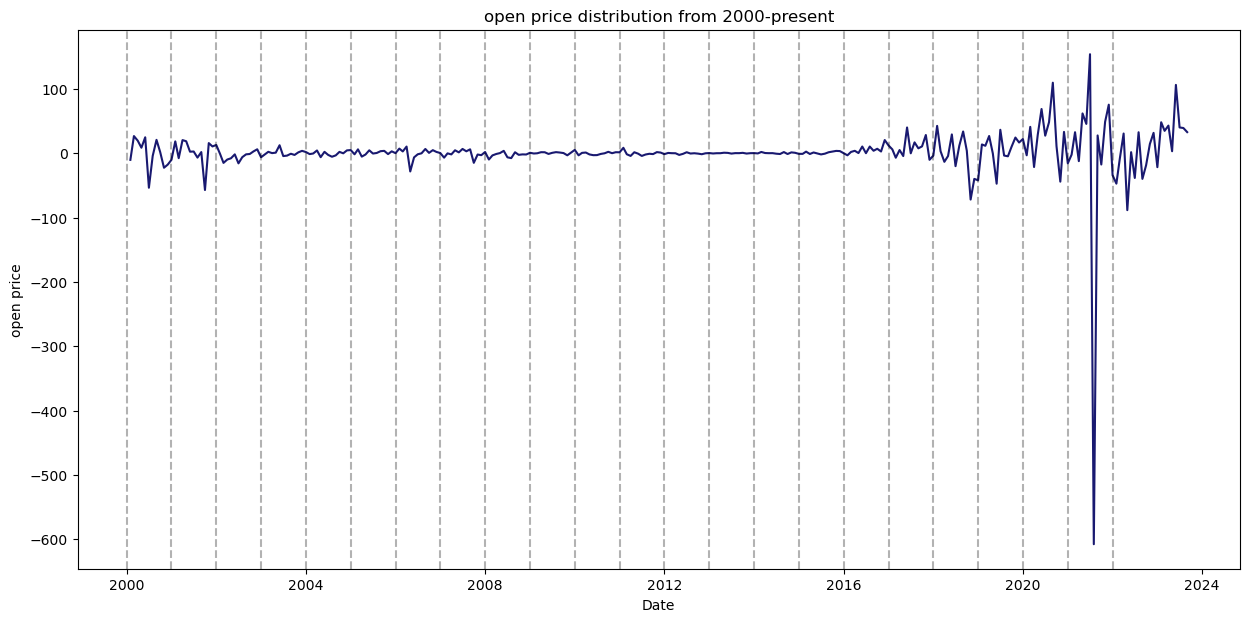

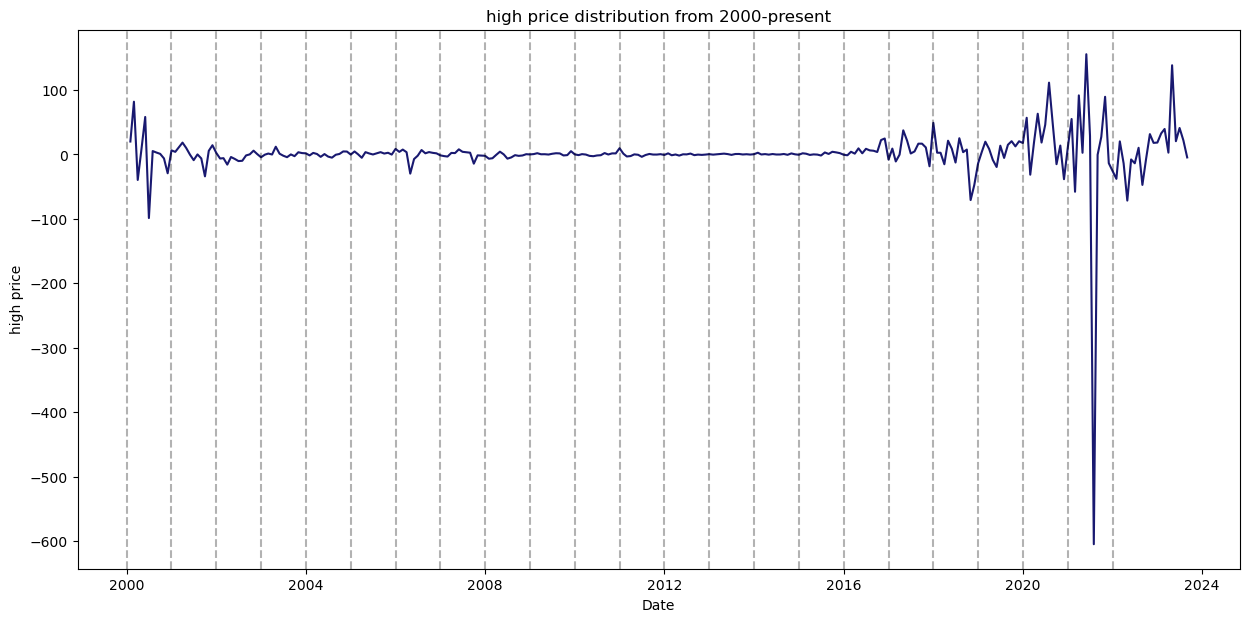

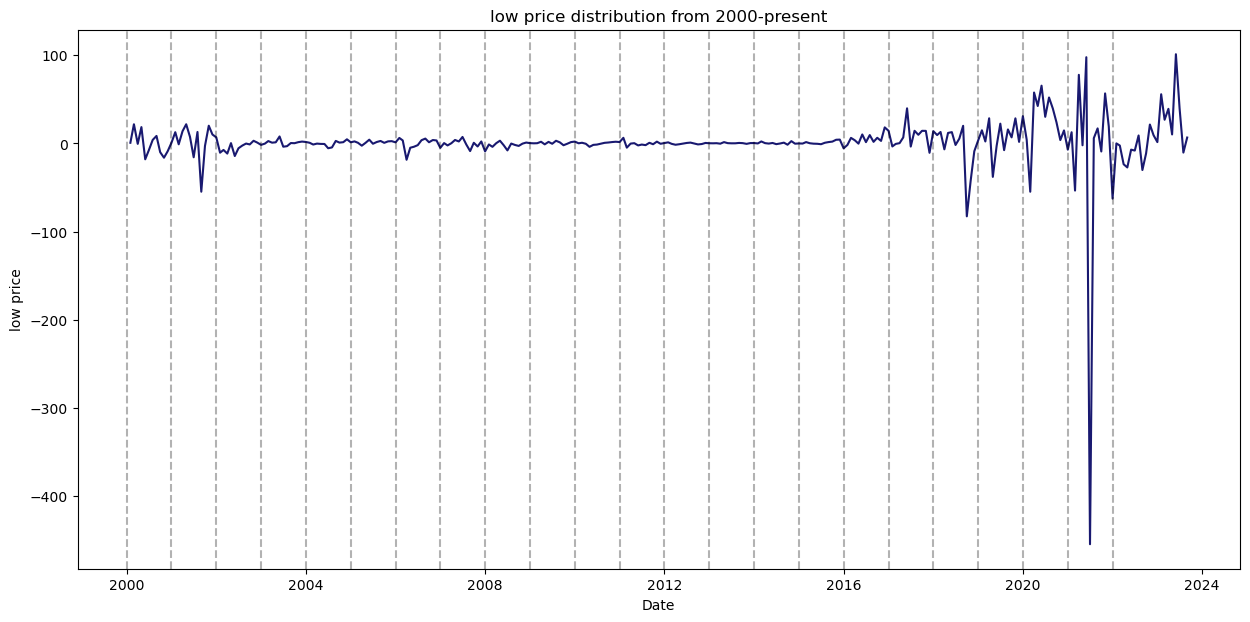

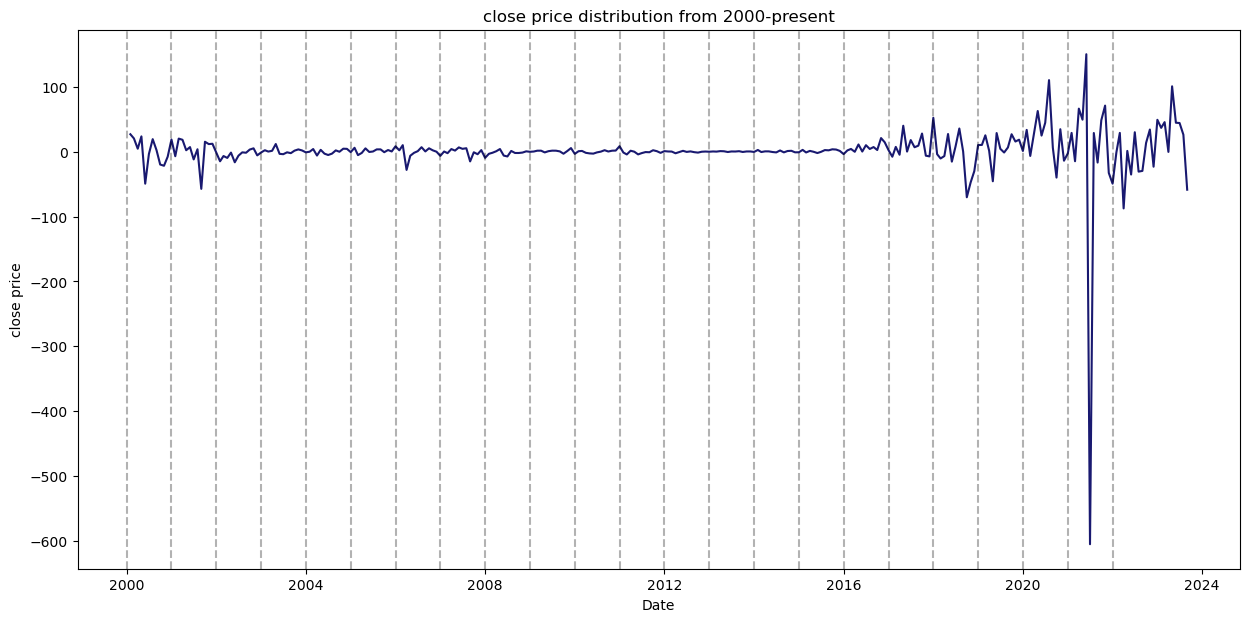

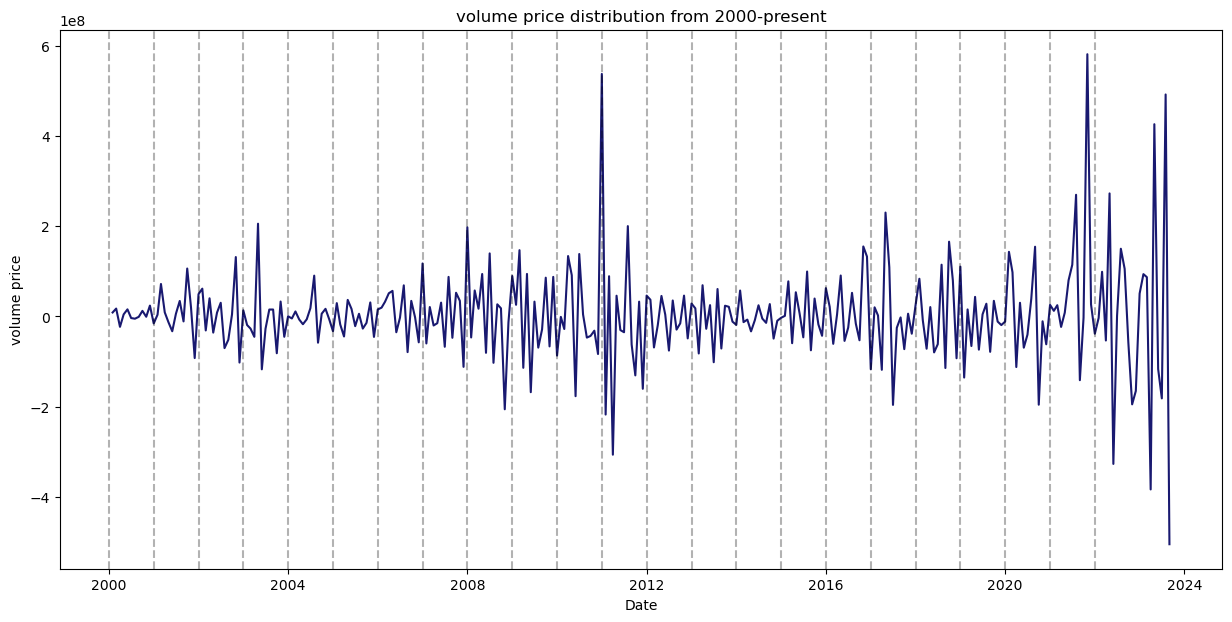

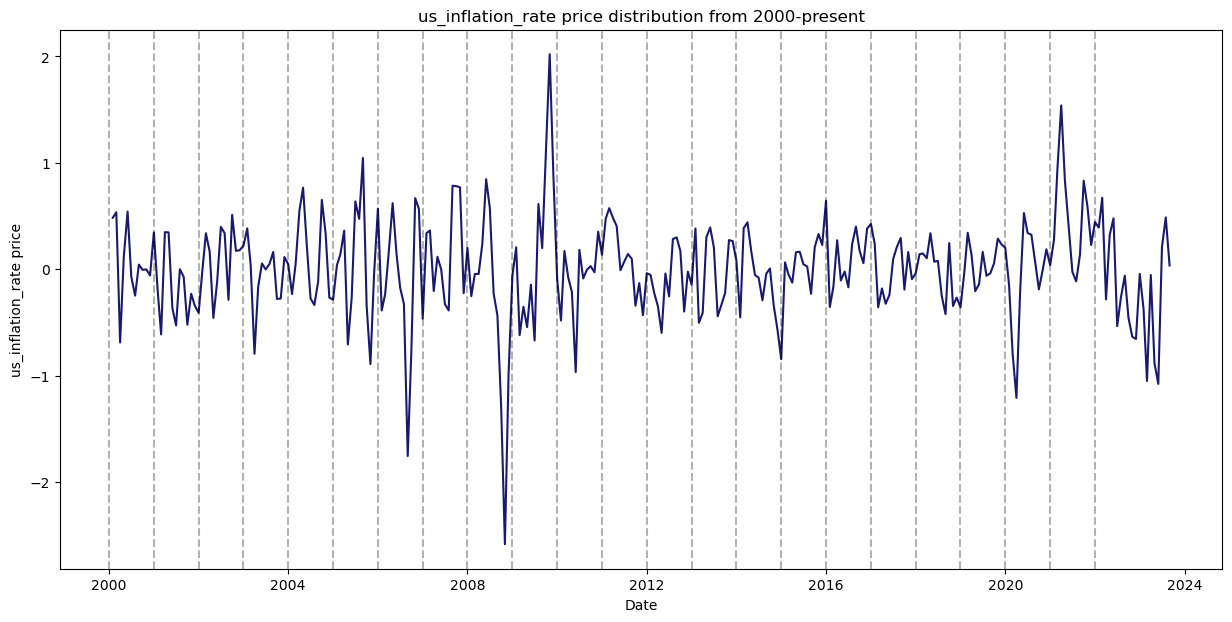

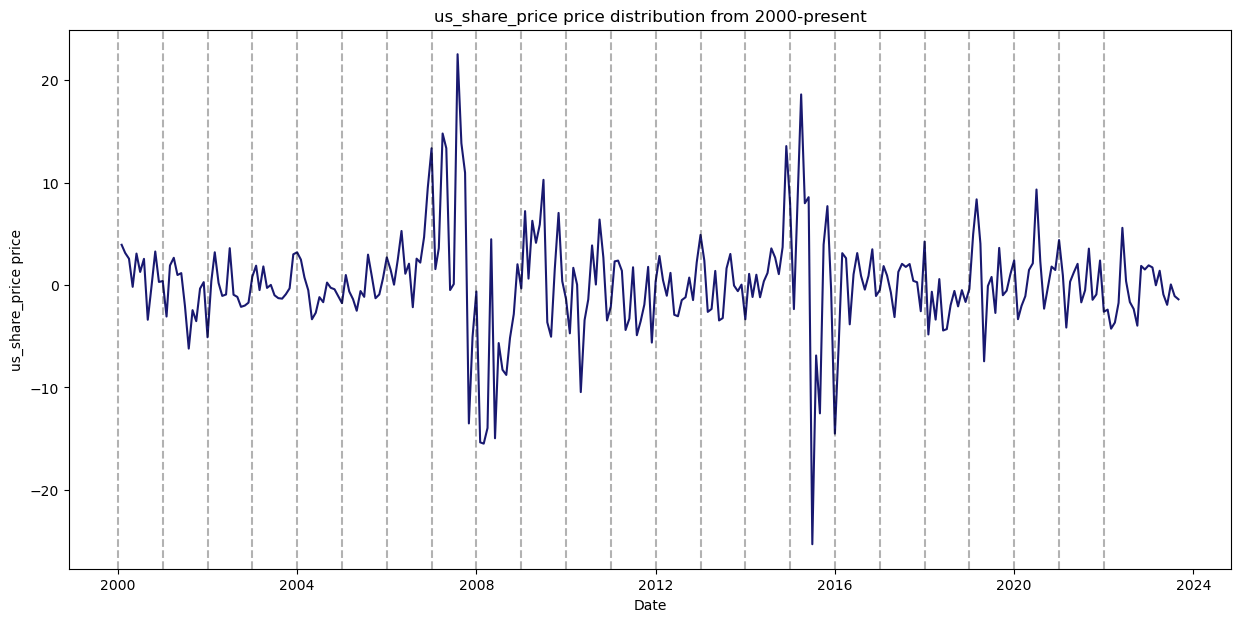

In [8]:
for col in data.columns.values:
    col_name = globals()[f'{col}_data']
    plot_price(col_name)


In [9]:
close_std = close_data.groupby([close_data.index.year]).std()
open_std = open_data.groupby([open_data.index.year]).std()
high_std = high_data.groupby([high_data.index.year]).std()
low_std = low_data.groupby([low_data.index.year]).std()
volume_std = volume_data.groupby([volume_data.index.year]).std()
us_inflation_rate_std = us_inflation_rate_data.groupby([us_inflation_rate_data.index.year]).std()
us_share_price_std = us_share_price_data.groupby([us_share_price_data.index.year]).std()

close_volatility = close_data.index.map(lambda dt: close_std.loc[dt.year])
open_volatility = open_data.index.map(lambda dt: open_std.loc[dt.year])
high_volatility = high_data.index.map(lambda dt: high_std.loc[dt.year])
low_volatility = low_data.index.map(lambda dt: low_std.loc[dt.year])
volume_volatility = volume_data.index.map(lambda dt: volume_std.loc[dt.year])
us_inflation_rate_volatility = us_inflation_rate_data.index.map(lambda dt: us_inflation_rate_std.loc[dt.year])
us_share_price_volatility = us_share_price_data.index.map(lambda dt: us_share_price_std.loc[dt.year])

close_data = pd.Series(close_data / close_volatility, name='close')
open_data = pd.Series(open_data / open_volatility, name='open')
high_data = pd.Series(high_data / high_volatility, name='high')
low_data = pd.Series(low_data / low_volatility, name='low')
volume_data = pd.Series(volume_data / volume_volatility, name='volume')
us_inflation_rate_volatility = pd.Series(us_inflation_rate_data / us_inflation_rate_volatility, name='inflation_rate')
us_share_price_volatility = pd.Series(us_share_price_data / us_share_price_volatility, name='share_price')

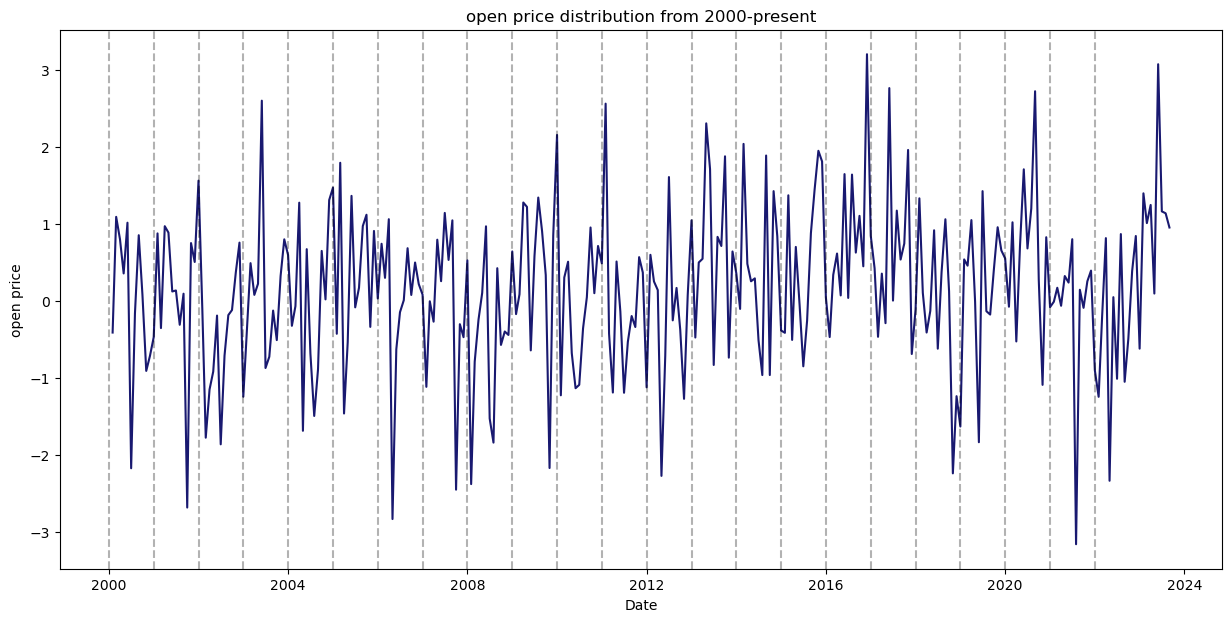

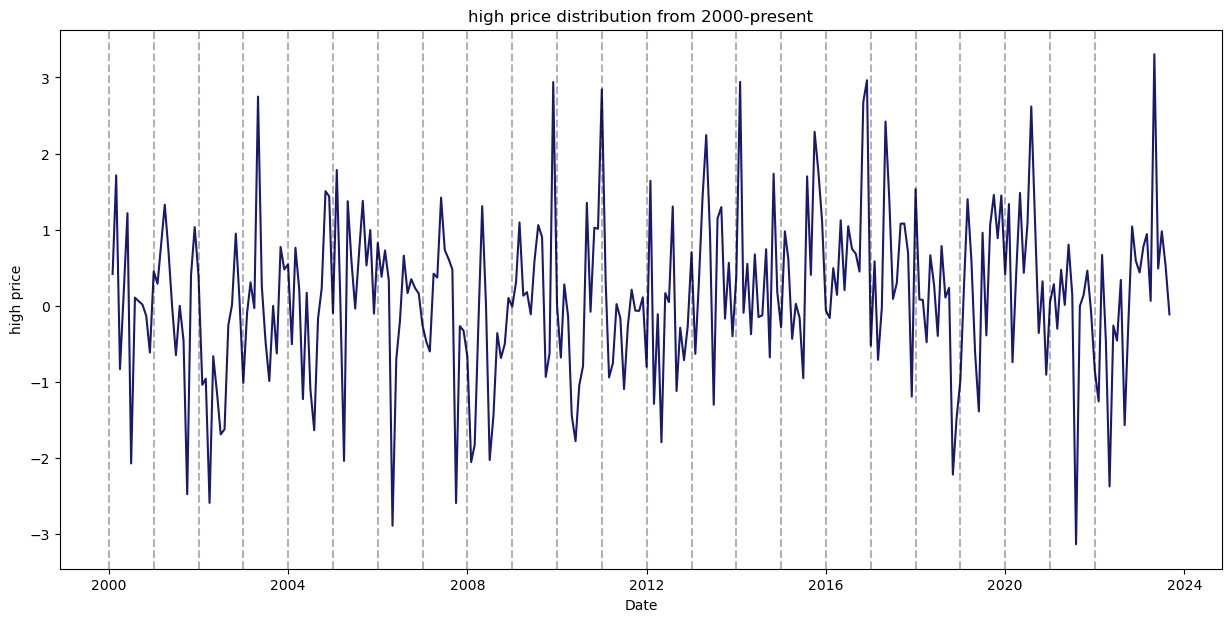

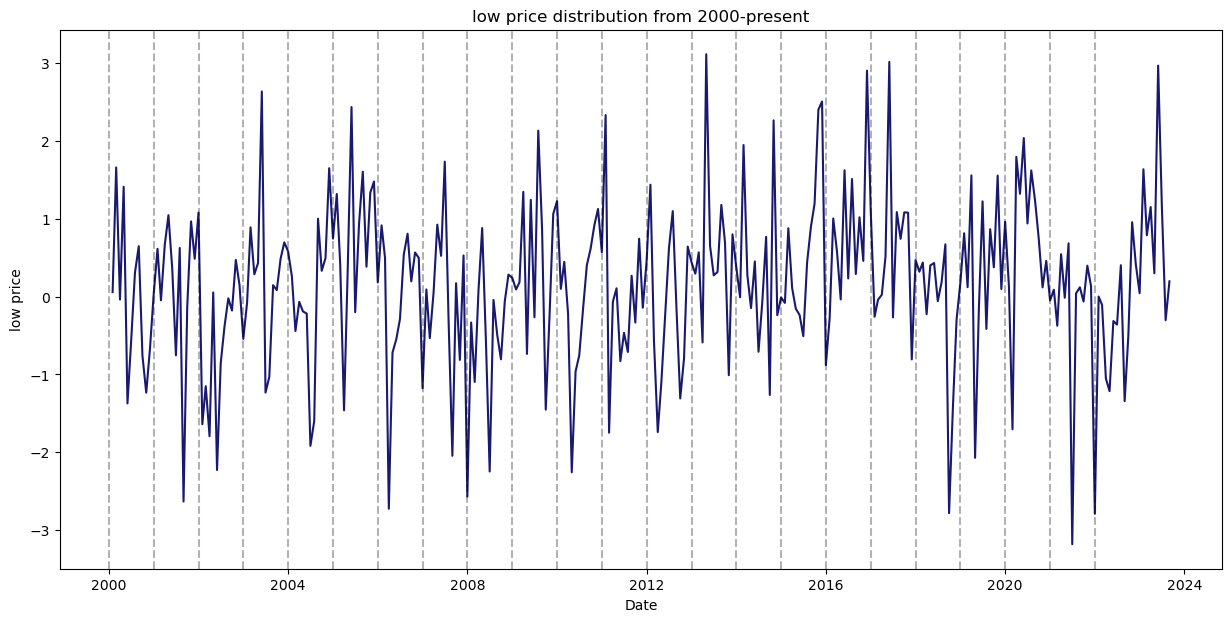

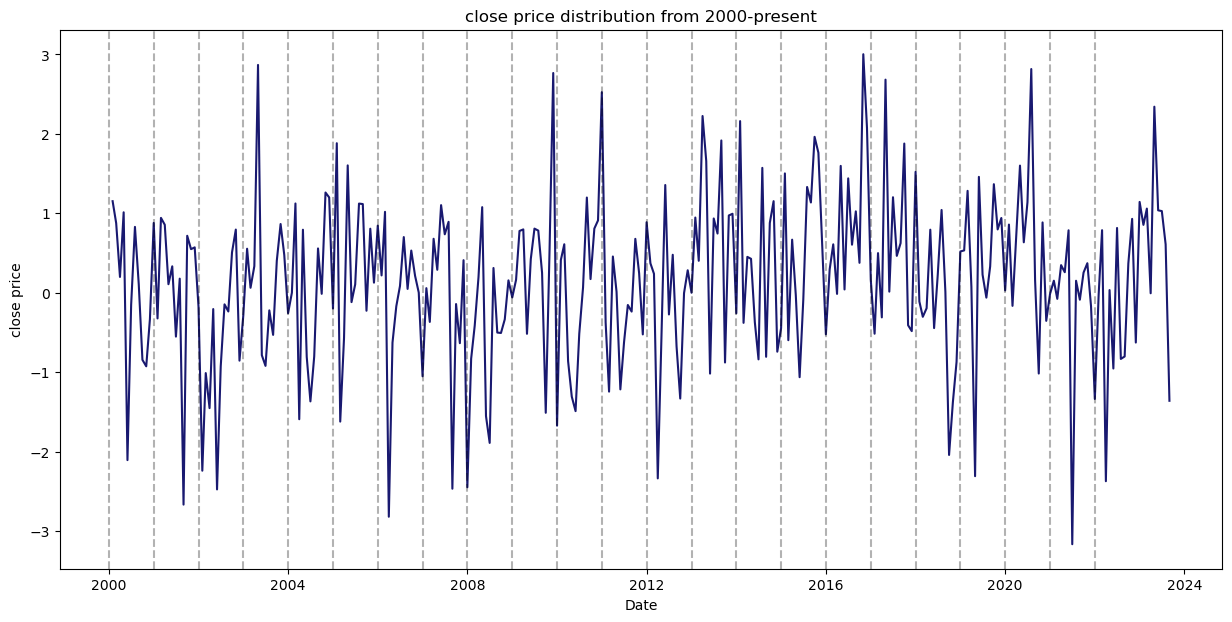

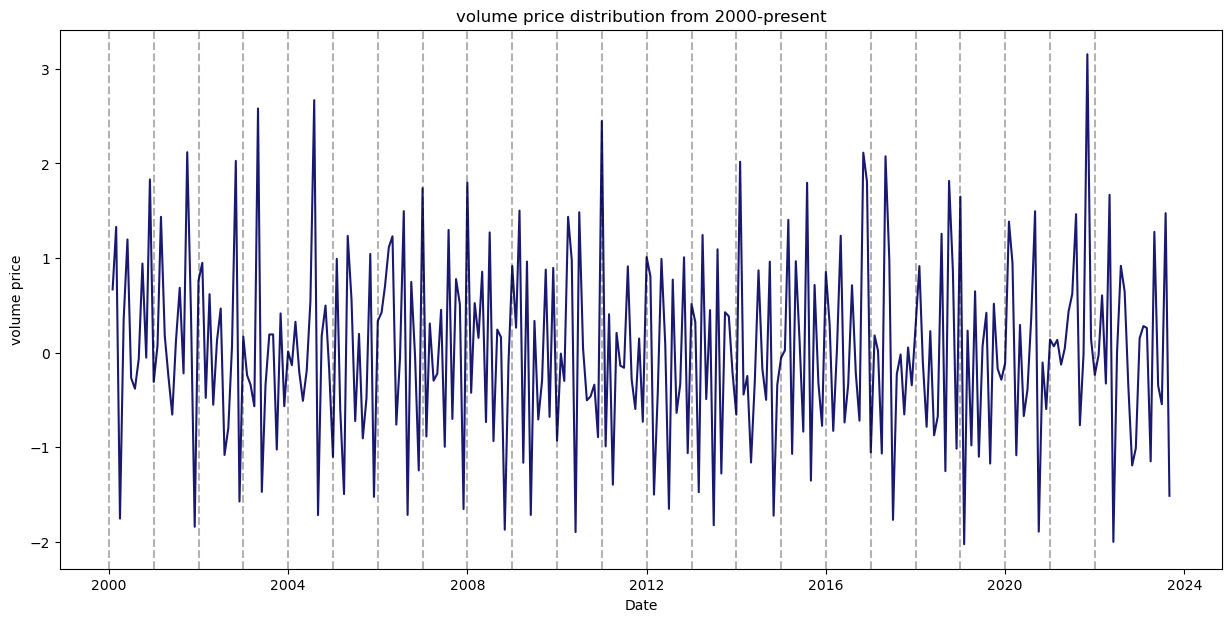

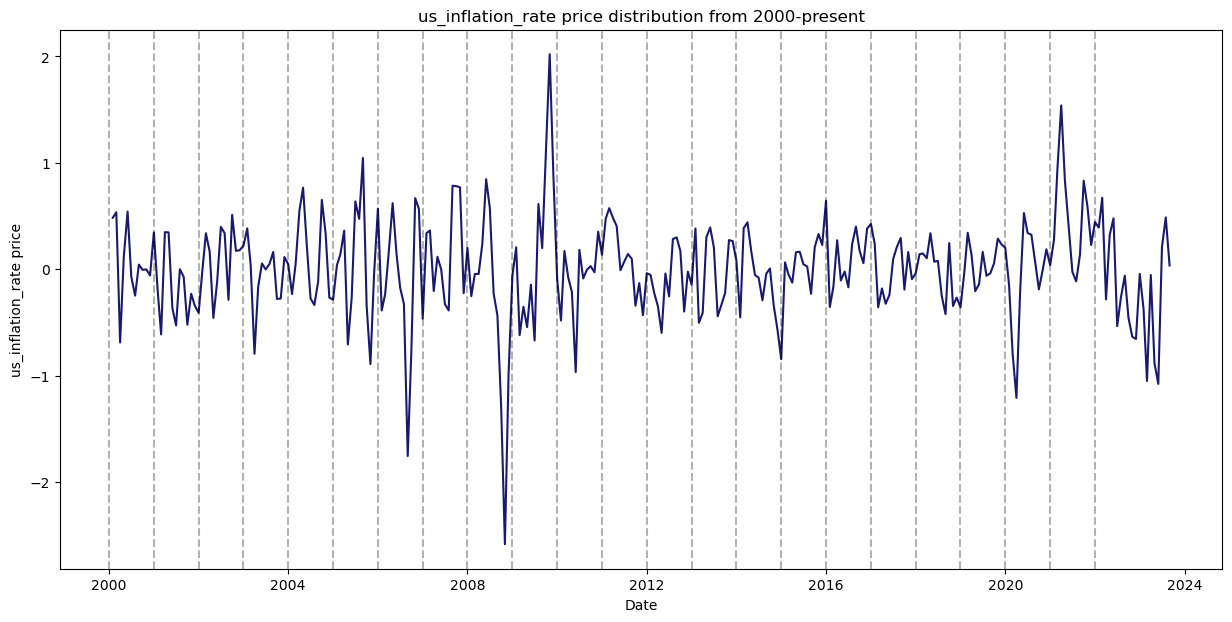

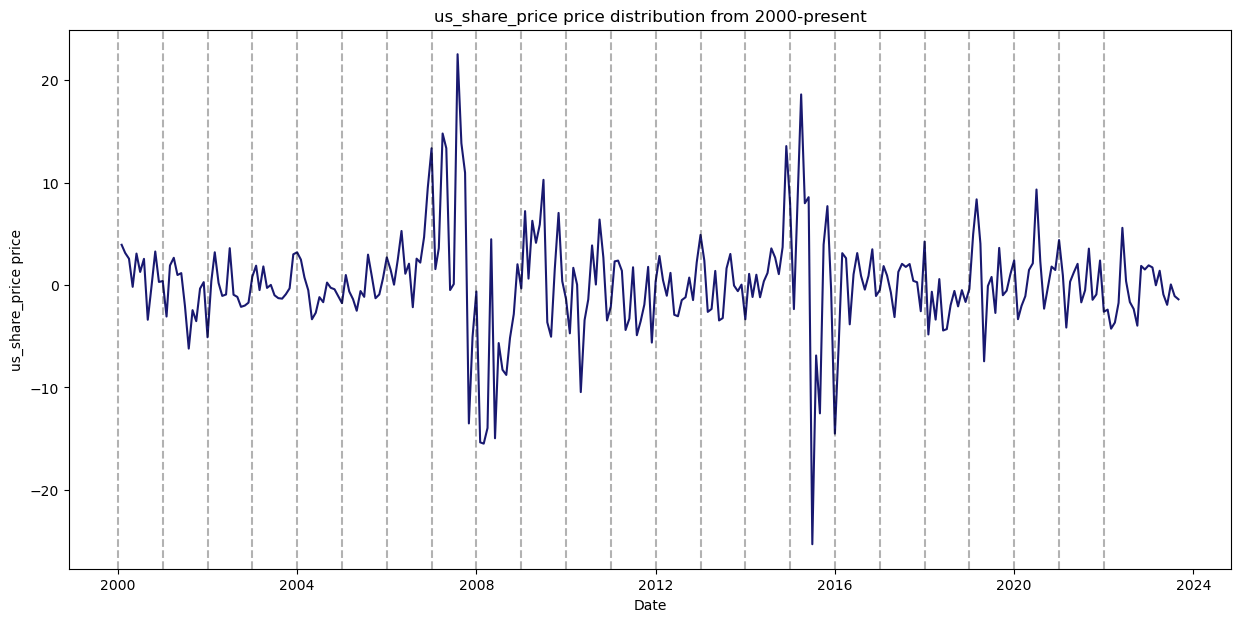

In [10]:
for col in data.columns.values:
    col_name = globals()[f'{col}_data']
    plot_price(col_name)

In [11]:
final_data = pd.DataFrame({'open': open_data.values,
                           'high': high_data.values,
                           'low': low_data.values,
                           'close': close_data.values,
                           'volume': volume_data.values,
                           'us_inflation_rate': us_inflation_rate_data,
                           'us_share_price': us_share_price_data},
                            index=data.index[1:])

In [12]:
start_date = date(2000, 2, 1)
end_date = date(2022, 12, 1)

month_diff = math.ceil((end_date - start_date).days / 30)
train_start_idx = final_data.index[0]
train_end_idx = final_data.index[month_diff]

test_start_idx = final_data.index[month_diff+1]


x = ['open', 'high', 'low', 'volume', 'us_inflation_rate', 'us_share_price']
y = ['close']

train_data = final_data[:train_end_idx]
test_data = final_data[test_start_idx:]

In [13]:
arima_model = ARIMA(endog=train_data.loc[:, y],
                    exog=train_data.loc[:, x],
                    order=(1, 0, 1))

model_fit = arima_model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  279
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -216.841
Date:                Wed, 22 Nov 2023   AIC                            453.681
Time:                        00:19:12   BIC                            489.993
Sample:                    02-01-2000   HQIC                           468.248
                         - 04-01-2023                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0376      0.021      1.790      0.073      -0.004       0.079
open                 -0.6168      0.046    -13.471      0.000      -0.707      -0.527
high                  0.

In [14]:
predicted_close = model_fit.predict(start=test_data.index[0],
                                    end=test_data.index[-1],
                                    exog=test_data.loc[:, x])

residuals = test_data['close'].values - predicted_close

# get the RMSE value to see how well the model performed

print(f"Root Mean Square Error: {np.sqrt(np.mean(residuals**2))}")

Root Mean Square Error: 0.6760324245090864


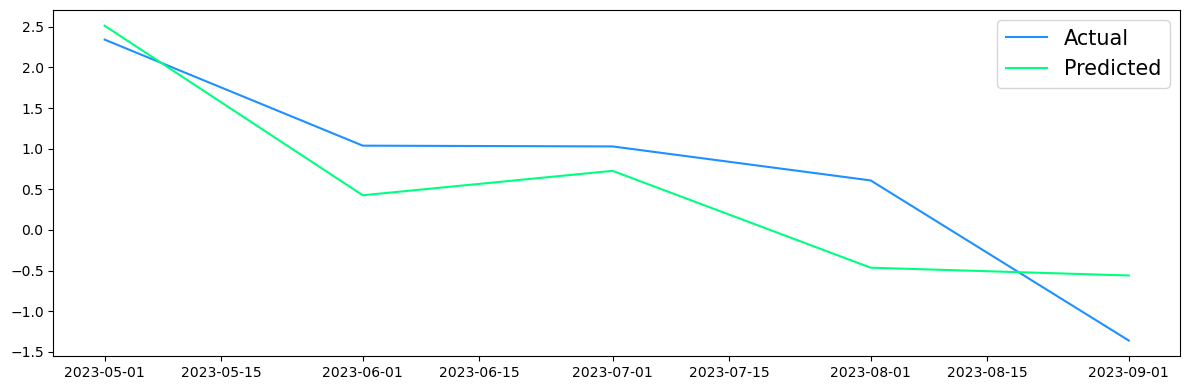

In [15]:

plt.figure(figsize=(12, 4))
plt.plot(test_data['close'], color='dodgerblue')
plt.plot(predicted_close, color='springgreen')

plt.legend(('Actual', 'Predicted'), fontsize=15)
plt.tight_layout()
plt.show()
